In [1]:
import numpy as np

import torch
import h5py

import matplotlib.pyplot as plt

%matplotlib inline

/Users/kompa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read data

- X = gene expression data
- y = 1/0 label for cancerous / not cancerous 
- cancer = string label of cancer type

In [59]:
## Training data
tcga = h5py.File('data/tcga_01_clipped.h5', mode='r') 
u_cancers = list(tcga['tcga/train'])

X = np.vstack(list([tcga['tcga/train/'+c] for c in u_cancers]))
cancer = np.array([c for c in u_cancers for i in range(tcga['tcga/train/'+c].shape[0])])

# Labels
tcga_labels = h5py.File('data/tcga_01_labels.h5', mode='r') 
y = np.concatenate([list(tcga_labels['tcga/train/'+c]) for c in u_cancers])

In [60]:
## Test data
#tcga = h5py.File('data/tcga_01.h5', mode='r') 
u_cancers = list(tcga['tcga/test'])

X_test = np.vstack(list([tcga['tcga/test/'+c] for c in u_cancers]))
cancer_test = np.array([c for c in u_cancers for i in range(tcga['tcga/test/'+c].shape[0])])

# Labels
#tcga_labels = h5py.File('data/tcga_01_labels.h5', mode='r') 
y_test = np.concatenate([list(tcga_labels['tcga/test/'+c]) for c in u_cancers])

## EDA

In [61]:
import pandas as pd

In [62]:
df = pd.concat([
    pd.DataFrame(y, columns=['y']),
    pd.DataFrame(cancer, columns=['cancer'])
],axis=1)

In [63]:
cancer_summary = df.groupby('cancer').agg({'y': ['mean','count']}).sort_values(by=[('y','count'),('y','mean')], ascending=True)

cancer_summary

y      
            mean count
cancer                
chol    0.838710    31
dlbc    1.000000    34
ucs     1.000000    40
read    1.000000    50
acc     1.000000    55
uvm     1.000000    56
meso    1.000000    61
kich    0.671875    64
thym    0.976471    85
tgct    1.000000    97
gbm     1.000000   116
laml    1.000000   121
paad    0.976562   128
pcpg    0.977099   131
coad    1.000000   134
esca    0.941606   137
sarc    0.994624   186
ov      1.000000   215
cesc    0.990741   216
kirp    0.911504   226
ucec    0.969925   266
lihc    0.871622   296
blca    0.956522   299
stad    0.904762   315
skcm    1.000000   331
lgg     1.000000   371
prad    0.896104   385
lusc    0.893782   386
hnsc    0.919192   396
thca    0.891960   398
luad    0.888337   403
kirc    0.879717   424
brca    0.908019   848

#### Accuracy from predicting cancerous always

In [64]:
np.mean(y)

0.9337077112724285

In [65]:
np.mean(y_test)

0.9477468839884947

#### UMAP

In [65]:
from umap import UMAP

In [104]:
c = 'chol'

idx_c = np.where(cancer==c)[0]

Xc = X[idx_c, :]
yc = y[idx_c]

In [105]:
Zc = UMAP(n_components=2, verbose=True).fit_transform(Xc)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


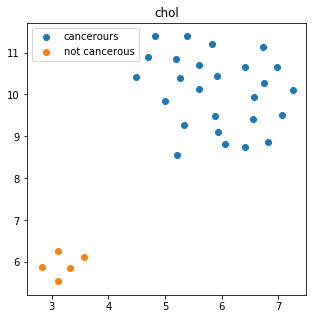

In [106]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(Zc[yc==1,0],Zc[yc==1,1])
ax.scatter(Zc[yc==0,0],Zc[yc==0,1])
ax.legend(['cancerours','not cancerous'])
ax.set_title(c)

## Classification for single cancer

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
c = 'chol'

idx_c = np.where(cancer==c)[0]

Xc = X[idx_c, :]
yc = y[idx_c]

In [11]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [12]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(Xc, yc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [13]:
clf.score(Xc,yc)

1.0

## Try classifying all cancer types

In [67]:
#cancer_use = cancer_summary[cancer_summary[('y','mean')] <= .95]
cancer_use = cancer_summary # Use this if you want to compare to all domain classifier 

cancer_use

y      
            mean count
cancer                
chol    0.838710    31
dlbc    1.000000    34
ucs     1.000000    40
read    1.000000    50
acc     1.000000    55
uvm     1.000000    56
meso    1.000000    61
kich    0.671875    64
thym    0.976471    85
tgct    1.000000    97
gbm     1.000000   116
laml    1.000000   121
paad    0.976562   128
pcpg    0.977099   131
coad    1.000000   134
esca    0.941606   137
sarc    0.994624   186
ov      1.000000   215
cesc    0.990741   216
kirp    0.911504   226
ucec    0.969925   266
lihc    0.871622   296
blca    0.956522   299
stad    0.904762   315
skcm    1.000000   331
lgg     1.000000   371
prad    0.896104   385
lusc    0.893782   386
hnsc    0.919192   396
thca    0.891960   398
luad    0.888337   403
kirc    0.879717   424
brca    0.908019   848

In [68]:
#unbalanced
cancer_clfs = list(cancer_use.index.values.astype(str))

acc = np.full((len(cancer_clfs),2), np.nan)
clfs = list()

for i,c in enumerate(cancer_clfs):
    
    # Subset data
    idx_c = np.where(cancer==c)[0]
    Xc = X[idx_c, :]
    yc = y[idx_c]
    
    idx_c = np.where(cancer_test==c)[0]
    Xc_test = X_test[idx_c, :]
    yc_test = y_test[idx_c]

    # Run RF
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    clf.fit(Xc, yc)
    
    clfs.append(clf)
    acc[i,:] = (clf.score(Xc,yc), clf.score(Xc_test,yc_test))

In [69]:
pd.concat([cancer_use, pd.DataFrame(acc, columns=['acc_train','acc_test'], index=cancer_use.index)],axis=1)

,"(y, mean)","(y, count)",acc_train,acc_test
cancer,,,,
chol,0.838710,31,1.000000,1.000000
dlbc,1.000000,34,1.000000,1.000000
ucs,1.000000,40,1.000000,1.000000
read,1.000000,50,1.000000,1.000000
acc,1.000000,55,1.000000,1.000000
uvm,1.000000,56,1.000000,1.000000
meso,1.000000,61,1.000000,1.000000
kich,0.671875,64,1.000000,1.000000
thym,0.976471,85,1.000000,1.000000


In [176]:
#balanced
cancer_clfs = list(cancer_use.index.values.astype(str))

acc = np.full((len(cancer_clfs),2), np.nan)
balanced_clfs = list()

for i,c in enumerate(cancer_clfs):
    
    # Subset data
    idx_c = np.where(cancer==c)[0]
    Xc = X[idx_c, :]
    yc = y[idx_c]
    
    idx_c = np.where(cancer_test==c)[0]
    Xc_test = X_test[idx_c, :]
    yc_test = y_test[idx_c]

    # Run RF
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight='balanced')
    clf.fit(Xc, yc)
    
    balanced_clfs.append(clf)
    acc[i,:] = (clf.score(Xc,yc), clf.score(Xc_test,yc_test))

In [177]:
pd.concat([cancer_use, pd.DataFrame(acc, columns=['acc_train','acc_test'], index=cancer_use.index)],axis=1)

,"(y, mean)","(y, count)",acc_train,acc_test
cancer,,,,
chol,0.838710,31,1.000000,1.000000
dlbc,1.000000,34,1.000000,1.000000
ucs,1.000000,40,1.000000,1.000000
read,1.000000,50,1.000000,1.000000
acc,1.000000,55,1.000000,1.000000
uvm,1.000000,56,1.000000,1.000000
meso,1.000000,61,1.000000,1.000000
kich,0.671875,64,1.000000,1.000000
thym,0.976471,85,1.000000,1.000000


In [190]:
np.where(cancer_use.index.values=='meso')

(array([6]),)

## Classifier on entire dataset

In [173]:
clf_all = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight='balanced')
clf_all.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [174]:
# Accuracy on training data
#95.02 unblanced 
#92.72 balanced
clf_all.score(X,y)

0.9272702369538419

In [175]:
# Accuracy on test data
#95.87 unblanced
#90.74 balanced 
clf_all.score(X_test,y_test)

0.9074784276126558

## Our method
First identify cancer, then use cancer specific classifier

#### Import trained VAE

In [70]:
#import stuff 
import yaml
import os
import sys
import shutil
import numpy as np
import torch
import h5py

from itertools import cycle

from torch.backends import cudnn
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable, grad

from src.data import LoadDataset
from src.ufdn import LoadModel

#We'll need to modify this for 3+ domains
from src.util import vae_loss, calc_gradient_penalty, interpolate_vae_3d

from tensorboardX import SummaryWriter 

In [71]:
#set this to the path of this yaml file 
#get it from my github branch 
config_path = 'config/tcga_domains.yaml'

In [72]:
conf = yaml.load(open(config_path,'r'))
exp_name = conf['exp_setting']['exp_name']
#img_size is only used in conv nets
#originally it was 64
img_size = conf['exp_setting']['img_size']
#20,501 img_depth
img_depth = conf['exp_setting']['img_depth']
domains = conf['exp_setting']['domains']
number_of_domains = len(domains)


data_root = conf['exp_setting']['data_root']
batch_size = conf['trainer']['batch_size']


enc_dim = conf['model']['vae']['encoder'][-1][1] #latent space dimension #100
code_dim = conf['model']['vae']['code_dim'] #number of domains #currently 3 
vae_learning_rate = conf['model']['vae']['lr'] #learning rate #10e-4
vae_betas = tuple(conf['model']['vae']['betas']) #used for adam optimizer


In [73]:
#load the model in a blank form 
vae = LoadModel('vae',conf['model']['vae'],img_size,img_depth)

In [74]:
#load in the trained params
#put statedict.pt in the same directory as this ipynb 
vae.load_state_dict(torch.load('statedict_clipped.pt'))

In [75]:
#set to eval mode, very important (so it doesn't train)
vae.eval()

UFDN(
  (enc_0): Sequential(
    (0): Linear(in_features=20501, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc_mu): Sequential(
    (0): Linear(in_features=500, out_features=100, bias=True)
  )
  (enc_logvar): Sequential(
    (0): Linear(in_features=500, out_features=100, bias=True)
  )
  (dec_0): Sequential(
    (0): Linear(in_features=133, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (dec_1): Sequential(
    (0): Linear(in_features=500, out_features=20501, bias=True)
  )
)

In [76]:
# Order of cancers for vae
cancer_vae = ['brca',
           'acc',
           'blca',
           'cesc',
           'chol',
           'coad',
           'dlbc',
           'esca',
           'gbm',
           'hnsc',
           'kich',
           'kirc',
           'kirp',
           'laml',
           'lgg',
           'lihc',
           'luad',
           'lusc',
           'meso',
           'ov',
           'paad',
           'pcpg',
           'prad',
           'read',
           'sarc',
           'skcm',
           'stad',
           'tgct',
           'thca',
           'thym',
           'ucec',
           'ucs',
           'uvm']

#### Now run method

In [77]:
def predict_cancer(x,vae,n_cancer):
    '''
    Predicts domain by encoding and then decoding to each domain
    Domain with smallest RMSE reconstruction error is the predicted domain
    '''
    # Encode to latent space
    enc = vae(Variable(torch.FloatTensor(x).unsqueeze(0)),return_enc=True).cpu().data.numpy().ravel()
    
    # Domain vectors (one for each domain)
    alphas = np.identity(n_cancer)
    alphas = [Variable(torch.FloatTensor(a).unsqueeze(0).expand((1, n_cancer))) for a in alphas]

    # Decode to each domain
    dec = [vae.decode(Variable(torch.FloatTensor(enc).unsqueeze(0)), alpha).data.numpy().ravel() \
       for alpha in alphas]
    
    # Return index of minum error domain
    error = np.array([np.sqrt(np.mean((x-d)**2)) for d in dec])
    return(np.argmin(error))

def predict_cancerous(x, vae, cancer_vae, clfs, cancer_clfs):
    '''
    cancer_vae and cancer_clfs are ordered lists of the cancer types for the vae and classifiers 
    '''
    
    # Predict cancer (domain)
    idx_vae = predict_cancer(x,vae,len(cancer_vae))
    cancer_pred = cancer_vae[idx_vae]
    
    # Predict cancerous / not cancerous using domain specific classifier
    idx_clfs = np.where(cancer_pred == np.array(cancer_clfs))[0][0]
    y_pred = clfs[idx_clfs].predict(x.reshape(1,-1))[0]
    
    return(cancer_pred, y_pred)

In [79]:
# Try it out
predict_cancerous(X[0,:], vae, cancer_vae, clfs, cancer_clfs)

('acc', 1)

In [80]:
# Predict on all test data (SLOW)
res = [predict_cancerous(x, vae, cancer_vae, clfs, cancer_clfs) for x in X_test]

In [179]:
train_res = [predict_cancerous(x, vae, cancer_vae, clfs, cancer_clfs) for x in X]

In [81]:
cancer_pred = np.array(list(zip(*res))[0])
y_pred = np.array(list(zip(*res))[1])

In [180]:
train_cancer_pred = np.array(list(zip(*train_res))[0])
train_y_pred = np.array(list(zip(*train_res))[1])

In [82]:
# Accuracy of cancer type
np.mean(cancer_test == cancer_pred)

0.9410354745925216

In [181]:
np.mean(cancer == train_cancer_pred)

0.9650732776332009

In [84]:
# Accuracy of cancerous / not cancerous
np.mean(y_pred == y_test)

0.9841802492809204

In [182]:
np.mean(train_y_pred == y)

0.9960279413778934

## A different way of classifying 
For each cancer type in the training set: 
* Take the cancer to a new domain 
* Evaluate with the random forest in that domain 

In [106]:
def translate_to_domain(x, vae, domain): 
    '''Takes input x, encodes it via vae and 
       decodes it to the new domain (numbered by cancer_vae)
    '''
    # Encode to latent space
    enc = vae(Variable(torch.FloatTensor(x).unsqueeze(0)),return_enc=True).cpu().data.numpy().ravel()
    # Domain vectors (one for each domain)
    alphas = np.identity(33)
    # The domain we are translating to
    alpha = Variable(torch.FloatTensor(alphas[domain,:] ).unsqueeze(0).expand((1, 33)))
    
    # Decode to new domain 
    dec = vae.decode(Variable(torch.FloatTensor(enc).unsqueeze(0)), alpha).data.numpy().ravel() 
    
    return(dec)

def partial_translate_to_domain(x, vae, original_domain, domain, fraction): 
    '''Takes input x, encodes it via vae and 
       decodes it to the new domain (numbered by cancer_vae)
    '''
    # Encode to latent space
    enc = vae(Variable(torch.FloatTensor(x).unsqueeze(0)),return_enc=True).cpu().data.numpy().ravel()
    # Domain vectors (one for each domain)
    alphas = np.identity(33)
    
    alphas[domain,original_domain] = 1.0 - fraction
    
    alphas[domain, domain] = float(fraction)
    
    alpha = Variable(torch.FloatTensor(alphas[domain,:] ).unsqueeze(0).expand((1, 33)))
    
    # Decode to new domain 
    dec = vae.decode(Variable(torch.FloatTensor(enc).unsqueeze(0)), alpha).data.numpy().ravel() 
    
    return(dec)
    
def translate_dataset(X, vae, domain):
    return(np.vstack(list([translate_to_domain(x, vae, domain) for x in X])))

def partial_translate_dataset(X, vae, original_domain, domain, fraction):
    return(np.vstack(list([partial_translate_to_domain(x, vae, original_domain, domain, fraction) for x in X])))

def encode_sample(x, vae):
    return(vae(Variable(torch.FloatTensor(x).unsqueeze(0)),return_enc=True).cpu().data.numpy().ravel())

def encode_dataset(X, vae):
    return(np.vstack(list([encode_sample(x, vae) for x in X])))

#25 skcm 8 gbm 

In [108]:
#test it out 
partial_translate_dataset(X_sckm, vae, 25, 8, .25)

array([[-1.8288475e-02, -2.9258123e-02, -1.2456823e-02, ...,
         2.2706614e-01, -3.5740260e-02, -1.4557311e-02],
       [-3.0280422e-02, -1.1185566e-02, -3.3562437e-02, ...,
         2.2360374e-01,  1.9395027e-02,  3.4081426e-02],
       [-4.9343742e-03,  4.6027519e-02, -1.4557872e-02, ...,
         3.7853959e-01,  6.6065796e-02,  1.8353930e-03],
       ...,
       [-3.7577376e-04, -2.3008268e-03, -9.6138537e-02, ...,
         5.5171049e-01,  4.4418154e-03,  9.0560623e-02],
       [-1.2593228e-02,  1.1036115e-02, -2.9465942e-02, ...,
         4.8708832e-01,  5.9121968e-03,  4.9322288e-02],
       [-2.6648358e-02,  2.8281752e-03, -1.4526565e-03, ...,
        -3.7019204e-02,  5.6064676e-02, -2.0995457e-02]], dtype=float32)

In [87]:
#make an array to store results 
results_train = pd.DataFrame(0, index=cancer_vae, columns=cancer_vae)

In [185]:
results_test = pd.DataFrame(0, index=cancer_vae, columns=cancer_vae)

In [88]:
#test results for each cancer 
for i in range(len(cancer_vae)):
    for j in range(i, len(cancer_vae)):
        cancer_source = cancer_vae[i]
        #classifer cancer  
        cancer_clf = cancer_clfs[j]
        #domain for vae 
        cancer_clf_domain = np.where(cancer_clf==np.array(cancer_vae))[0][0]
        #index for classifer 
        cancer_clf_idx = np.where(cancer_clf==np.array(cancer_clfs))[0][0]
        
        #subset the data 
        idx_c = np.where(cancer==cancer_source)[0]
        Xc = X[idx_c, :]
        yc = y[idx_c]
        
        #translate dataset 
        
        Xc_clf_domain = translate_dataset(Xc, vae, cancer_clf_domain)
        
        classifer = clf[cancer_clf_idx]
        
        acc = classifer.score(Xc_clf_domain,yc)
        print(cancer_source, cancer_clf, acc)
        
        results_train.iloc[i,j] = acc 
        results_train.iloc[j,i] = acc 
        
        
        
        
        
        
        
        
        

brca chol 0.8089622641509434
brca dlbc 0.9292452830188679
brca ucs 0.9080188679245284
brca read 0.9080188679245284
brca acc 0.9410377358490566
brca uvm 0.9386792452830188
brca meso 0.7193396226415094
brca kich 0.910377358490566
brca thym 0.7393867924528302
brca tgct 0.9327830188679245
brca gbm 0.5931603773584906
brca laml 0.9080188679245284
brca paad 0.9091981132075472
brca pcpg 0.9068396226415094
brca coad 0.9516509433962265
brca esca 0.7983490566037735
brca sarc 0.9410377358490566
brca ov 0.09787735849056604
brca cesc 0.9127358490566038
brca kirp 0.9091981132075472
brca ucec 0.9245283018867925
brca lihc 0.9080188679245284
brca blca 0.9080188679245284
brca stad 0.9080188679245284
brca skcm 0.9127358490566038
brca lgg 0.9469339622641509
brca prad 0.9056603773584906
brca lusc 0.9528301886792453
brca hnsc 0.9540094339622641
brca thca 0.9257075471698113
brca luad 0.9610849056603774
brca kirc 0.9681603773584906
brca brca 0.9351415094339622
acc dlbc 1.0
acc ucs 1.0
acc read 1.0
acc acc 1.0


kirp cesc 0.915929203539823
kirp kirp 0.9070796460176991
kirp ucec 0.9247787610619469
kirp lihc 0.915929203539823
kirp blca 0.911504424778761
kirp stad 0.911504424778761
kirp skcm 0.9026548672566371
kirp lgg 0.9070796460176991
kirp prad 0.911504424778761
kirp lusc 0.8805309734513275
kirp hnsc 0.911504424778761
kirp thca 0.9380530973451328
kirp luad 0.911504424778761
kirp kirc 0.9070796460176991
kirp brca 0.911504424778761
laml pcpg 1.0
laml coad 1.0
laml esca 0.7355371900826446
laml sarc 1.0
laml ov 0.2892561983471074
laml cesc 0.9173553719008265
laml kirp 1.0
laml ucec 1.0
laml lihc 1.0
laml blca 1.0
laml stad 1.0
laml skcm 0.9834710743801653
laml lgg 1.0
laml prad 1.0
laml lusc 0.768595041322314
laml hnsc 0.9669421487603306
laml thca 1.0
laml luad 0.8925619834710744
laml kirc 0.8760330578512396
laml brca 1.0
lgg coad 0.9164420485175202
lgg esca 0.5660377358490566
lgg sarc 0.954177897574124
lgg ov 0.026954177897574125
lgg cesc 0.9919137466307277
lgg kirp 0.8652291105121294
lgg ucec 0.

In [89]:
results_train.mean(axis=1)

brca    0.871963
acc     0.907498
blca    0.911675
cesc    0.921821
chol    0.803028
coad    0.921653
dlbc    0.930030
esca    0.876069
gbm     0.825669
hnsc    0.891987
kich    0.614035
kirc    0.822406
kirp    0.868642
laml    0.896426
lgg     0.849020
lihc    0.771814
luad    0.913231
lusc    0.495184
meso    0.955970
ov      0.945470
paad    0.938472
pcpg    0.910345
prad    0.914465
read    0.955411
sarc    0.894356
skcm    0.930626
stad    0.925465
tgct    0.854064
thca    0.931782
thym    0.948451
ucec    0.935120
ucs     0.888705
uvm     0.950166
dtype: float64

In [195]:
#test results for each cancer 
total=0

for i in range(len(cancer_vae)):
    for j in [6]:
        cancer_source = cancer_vae[i]
        #classifer cancer  
        cancer_clf = cancer_clfs[j]
        #domain for vae 
        cancer_clf_domain = np.where(cancer_clf==np.array(cancer_vae))[0][0]
        #index for classifer 
        cancer_clf_idx = np.where(cancer_clf==np.array(cancer_clfs))[0][0]
        
        #subset the data 
        idx_c = np.where(cancer_test==cancer_source)[0]
        Xc = X_test[idx_c, :]
        yc = y_test[idx_c]
        
        #translate dataset 
        
        Xc_clf_domain = translate_dataset(Xc, vae, cancer_clf_domain)
        
        classifer = clf[cancer_clf_idx]
        
        acc = classifer.score(Xc_clf_domain,yc)
        total+=acc
        print(cancer_source, cancer_clf, acc)
        
        results_test.iloc[i,j] = acc 
        results_test.iloc[j,i] = acc 

brca meso 0.7489711934156379
acc meso 1.0
blca meso 0.9058823529411765
cesc meso 0.9838709677419355
chol meso 0.4444444444444444
coad meso 0.9473684210526315
dlbc meso 0.8888888888888888
esca meso 0.8461538461538461
gbm meso 1.0
hnsc meso 0.9203539823008849
kich meso 0.7777777777777778
kirc meso 0.8925619834710744
kirp meso 0.49230769230769234
laml meso 1.0
lgg meso 0.9811320754716981
lihc meso 0.8823529411764706
luad meso 0.8
lusc meso 0.8468468468468469
meso meso 0.9411764705882353
ov meso 0.6885245901639344
paad meso 0.918918918918919
pcpg meso 1.0
prad meso 0.9090909090909091
read meso 1.0
sarc meso 0.9423076923076923
skcm meso 0.8736842105263158
stad meso 0.7777777777777778
tgct meso 0.9285714285714286
thca meso 0.8938053097345132
thym meso 1.0
ucec meso 0.75
ucs meso 0.8181818181818182
uvm meso 0.625


In [196]:
total/33

0.8613925012076531

In [194]:
results_test.mean(axis=0)

brca    0.051069
acc     0.059504
blca    0.055524
cesc    0.059135
chol    0.042794
coad    0.056750
dlbc    0.861393
esca    0.055502
gbm     0.059300
hnsc    0.027890
kich    0.023569
kirc    0.027047
kirp    0.014918
laml    0.030303
lgg     0.029731
lihc    0.026738
luad    0.024242
lusc    0.025662
meso    0.259714
ov      0.020864
paad    0.027846
pcpg    0.030303
prad    0.027548
read    0.030303
sarc    0.028555
skcm    0.026475
stad    0.023569
tgct    0.028139
thca    0.027085
thym    0.030303
ucec    0.022727
ucs     0.024793
uvm     0.018939
dtype: float64

In [58]:
np.where(np.array(cancer_vae)=='brca')[0][0]

0

In [80]:
np.where('chol'==np.array(cancer_clfs))[0][0]

0

## Random Forest baseline for cancer class prediction 

In [201]:
cancer_RF = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0, verbose=0)

In [202]:
cancer_RF.fit(X, cancer)

KeyboardInterrupt: 

In [113]:
#training set accuracy 
cancer_RF.score(X, cancer)

0.9965758115326667

In [114]:
cancer_RF.score(X_test, cancer_test)

0.9520613614573347

In [ ]:
X_encode = encode_dataset(X, vae)
X_test_encode = encode_dataset(X_test, vae)

In [130]:
encode_cancer_RF = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, verbose=0)

In [131]:
encode_cancer_RF.fit(X_encode, cancer)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [132]:
encode_cancer_RF.score(X_encode, cancer)

1.0

In [133]:
encode_cancer_RF.score(X_test_encode, cancer_test)

0.87392138063279

In [134]:
#try K nearest neighbors 
from sklearn.neighbors import KNeighborsClassifier

In [137]:
#numeric cancer labels 
cancer_numeric = [np.where(c==np.array(cancer_vae))[0][0] for c in cancer]
cancer_test_numeric = [np.where(c==np.array(cancer_vae))[0][0] for c in cancer_test]

In [147]:
neigh = KNeighborsClassifier(n_neighbors=10)

In [148]:
neigh.fit(X_encode, cancer_numeric)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [149]:
neigh.score(X_encode, cancer_numeric)

0.8676893576222435

In [150]:
neigh.score(X_test_encode, cancer_test_numeric)

0.8446788111217641

In [199]:
def predict_cancerous_RF(x, vae, cancer_vae, clfs, cancer_clfs):
    '''
    cancer_vae and cancer_clfs are ordered lists of the cancer types for the vae and classifiers 
    '''
    
    # Predict cancer (domain)
    idx_RF = np.where(cancer_RF.predict(x.reshape(1,-1))==np.array(cancer_vae))[0][0]
    cancer_pred = cancer_vae[idx_RF]
    
    # Predict cancerous / not cancerous using domain specific classifier
    idx_clfs = np.where(cancer_pred == np.array(cancer_clfs))[0][0]
    y_pred = clfs[idx_clfs].predict(x.reshape(1,-1))[0]
    
    return(cancer_pred, y_pred)

In [200]:
# Predict on all test data (SLOW)
res = [predict_cancerous_RF(x, vae, cancer_vae, clfs, cancer_clfs) for x in X]

NameError: name 'cancer_RF' is not defined

In [170]:
cancer_pred = np.array(list(zip(*res))[0])
y_pred = np.array(list(zip(*res))[1])

In [171]:
# Accuracy of cancer type
np.mean(cancer_test == cancer_pred)

0.9520613614573347

In [172]:
# Accuracy of cancerous / not cancerous
np.mean(y_pred == y_test)

0.9841802492809204

## GO Term analysis 
take test skcm and transform into GBM 

In [93]:
X_sckm = X_test[np.where(np.array(cancer_test)=='skcm')[0],:]

In [176]:
X_gbm = X_test[np.where(np.array(cancer_test)=='gbm')[0],:]

In [94]:
gbm_domain_idx = np.where(np.array(cancer_vae)=='gbm')[0][0]
gbm_domain_idx

8

In [90]:
import pickle 
from sklearn import preprocessing

In [91]:
#the scaler that was used to preprocess the data
min_max_scaler_clipped = pickle.load(open('min_max_scaler_clipped.p','rb'))

In [95]:
X_sckm_to_gbm = translate_dataset(X_sckm, vae, gbm_domain_idx)

In [109]:
X_sckm_to_gbm_25 = partial_translate_dataset(X_sckm, vae, 25, 8, .25)

In [110]:
X_sckm_to_gbm_50 = partial_translate_dataset(X_sckm, vae, 25, 8, .5)

In [111]:
X_sckm_to_gbm_75 = partial_translate_dataset(X_sckm, vae, 25, 8, .75)

In [96]:
min_max_scaler_clipped.inverse_transform(X_sckm)

array([[  79.4085,    0.    ,    6.1538, ...,  436.2393,    7.1795,
           0.    ],
       [ 338.1503,    0.    ,    0.    , ...,  584.3931,    6.9364,
           0.    ],
       [ 499.2192,    0.    ,    0.    , ..., 1346.3467,   12.1777,
           0.    ],
       ...,
       [ 167.7144,    0.    ,    0.    , ..., 1055.2164,    4.2474,
           0.    ],
       [ 187.9862,    0.    ,    0.    , ..., 1337.4058,    6.1087,
           0.    ],
       [ 581.3953,    0.    ,    0.    , ...,  166.6667,   11.6279,
           0.    ]])

In [97]:
np.save('X_sckm_counts.npy', min_max_scaler_clipped.inverse_transform(X_sckm))

In [98]:
np.save('X_sckm_to_gbm_counts.npy', min_max_scaler_clipped.inverse_transform(X_sckm_to_gbm))

In [187]:
X_sckm

array([[1.44757338e-04, 0.00000000e+00, 1.00002100e-03, ...,
        4.65192259e-02, 5.82378178e-04, 0.00000000e+00],
       [6.22127819e-04, 0.00000000e+00, 0.00000000e+00, ...,
        6.47745114e-02, 5.62658680e-04, 0.00000000e+00],
       [9.19294872e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.58661273e-01, 9.87816246e-04, 0.00000000e+00],
       ...,
       [3.07678946e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.22788641e-01, 3.44535563e-04, 0.00000000e+00],
       [3.45079779e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.57559589e-01, 4.95518292e-04, 0.00000000e+00],
       [1.07090719e-03, 0.00000000e+00, 0.00000000e+00, ...,
        1.33029008e-02, 9.43218221e-04, 0.00000000e+00]])

In [190]:
np.load('X_sckm.npy')

array([[1.44757338e-04, 0.00000000e+00, 1.00002100e-03, ...,
        4.65192259e-02, 5.82378178e-04, 0.00000000e+00],
       [6.22127819e-04, 0.00000000e+00, 0.00000000e+00, ...,
        6.47745114e-02, 5.62658680e-04, 0.00000000e+00],
       [9.19294872e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.58661273e-01, 9.87816246e-04, 0.00000000e+00],
       ...,
       [3.07678946e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.22788641e-01, 3.44535563e-04, 0.00000000e+00],
       [3.45079779e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.57559589e-01, 4.95518292e-04, 0.00000000e+00],
       [1.07090719e-03, 0.00000000e+00, 0.00000000e+00, ...,
        1.33029008e-02, 9.43218221e-04, 0.00000000e+00]])

In [99]:
np.savetxt('X_sckm_counts.csv',min_max_scaler_clipped.inverse_transform(X_sckm), delimiter=',')

In [177]:
np.savetxt('X_gbm_counts.csv',min_max_scaler_clipped.inverse_transform(X_gbm), delimiter=',')

In [100]:
np.savetxt('X_sckm_to_gbm_counts.csv',min_max_scaler_clipped.inverse_transform(X_sckm_to_gbm), delimiter=',')

In [112]:
np.savetxt('X_sckm_to_gbm_25_counts.csv',min_max_scaler_clipped.inverse_transform(X_sckm_to_gbm_25), delimiter=',')

In [113]:
np.savetxt('X_sckm_to_gbm_50_counts.csv',min_max_scaler_clipped.inverse_transform(X_sckm_to_gbm_50), delimiter=',')

In [114]:
np.savetxt('X_sckm_to_gbm_75_counts.csv',min_max_scaler_clipped.inverse_transform(X_sckm_to_gbm_75), delimiter=',')

## Encode clipped dataset for Bokeh plotting 


In [169]:
clipped_encodings = encode_dataset(X, vae)

In [16]:
np.save(file='clipped_encodings.npy', arr=clipped_encodings)

In [119]:
## train UMAP

import numpy as np
from umap import UMAP


Z = UMAP(n_components=2, spread = 2.0, min_dist=0.01, verbose=True).fit_transform(clipped_encodings)


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.01, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=2.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


In [21]:
np.save('Z_clipped_encodings.npy',Z)

In [22]:
np.save('clipped_encoding_labels.npy', cancer)

In [23]:
import bokeh
from bokeh.plotting import figure, show 
from bokeh.io import output_notebook

In [27]:
numeric_labels = [np.where(np.array(cancer_vae)==label)[0][0] for label in cancer]

In [121]:
df = pd.concat([
    pd.DataFrame(Z, columns=["X1","X2"]),
    pd.DataFrame(numeric_labels, columns=["label"])
],axis=1)

In [29]:
radii = np.repeat(.1, df.shape[0])

In [30]:
import matplotlib
import matplotlib.pyplot as plt
norm = matplotlib.colors.Normalize(vmin=0, vmax=32)
cmap = plt.get_cmap('Spectral')

In [31]:
colors = [matplotlib.colors.rgb2hex(cmap(norm(label))) for label in numeric_labels]

In [136]:
df2 = pd.concat([df, 
                 pd.DataFrame(colors, columns=['colors']), 
                 pd.DataFrame(cancer, columns=['labels']),
                pd.DataFrame(radii, columns=['radii'])], axis=1)

In [38]:
output_notebook()

Loading BokehJS ...

In [126]:
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
p = figure(title='Encoding UMAP', tools=TOOLS) 

In [132]:
p.scatter(df['X1'].values, df['X2'].values, radius=radii,
          fill_color=colors, fill_alpha=1,
          line_color=None)

bokeh.models.renderers.GlyphRenderer(
    id='513bbe1d-03f4-47d4-bc99-242367de8adf',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='749cf63c-0032-41e2-8b21-3080350d76ce',
        callback=None,
        data={'radius': {'__ndarray__': 'mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/m

In [128]:
show(p)

## Plot data in bokeh 

In [170]:
Zdata = UMAP(n_components=2, spread = 2.0, min_dist=0.01, verbose=True).fit_transform(X)


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.01, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=2.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Construct embedding


/Users/kompa/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


In [171]:
Zdata.shape

(7301, 2)

In [172]:
df3 = pd.concat([
    pd.DataFrame(Zdata, columns=["X1","X2"]),
    pd.DataFrame(numeric_labels, columns=["label"])
],axis=1)

In [173]:
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
p2 = figure(title='TCGA UMAP', tools=TOOLS) 

In [174]:
p2.scatter(df3['X1'].values, df3['X2'].values, radius=radii,
          fill_color=colors, fill_alpha=1,
          line_color=None)

bokeh.models.renderers.GlyphRenderer(
    id='28095ba0-7631-4302-be91-39f4a55b31aa',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='b5b93549-45ef-4a33-9c47-f37f2b4b16eb',
        callback=None,
        data={'radius': {'__ndarray__': 'mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/mpmZmZmZuT+amZmZmZm5P5qZmZmZmbk/m

In [175]:
show(p2)